## **캡스톤치맥회동 AI 스터디 python**

### 스터디 개요
1. HuggingFace Hub의 imdb 데이터셋을 이용한 전처리 및 텍스트 토큰화
2. 학습, 검증, 테스트 로직 구현
3. 모델 성능 향상

### 스터디로 얻어갈 수 있는 능력
* HuggingFace Hub에서 데이터셋을 불러올 수 있습니다.
* train, validation, test 데이터셋을 분리할 수 있습니다.
* 텍스트 데이터를 전처리하고, 인코딩할 수 있습니다.
* 학습, 검증, 테스트 로직을 익힐 수 있습니다.

> [TODO]에 코드를 채워넣으면 됩니다!

## 0. 난수 시드 고정하기

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Pytorch CPU 연산 난수 시드를 고정합니다.
    torch.cuda.manual_seed_all(seed)  # 모든 GPU의 난수 시드를 고정합니다.

    # 매 실행마다 동일한 결과를 재현합니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## 1. 데이터셋 불러오기
* 허깅페이스의 imdb 데이터셋을 불러옵니다.
* 참고) imdb는 train, test 데이터셋을 지원합니다.

In [1]:
import pandas as pd
from datasets import load_dataset  # HuggingFace에서 지원하는 라이브러리입니다.

In [3]:
train_dataset = load_dataset("imdb", split="train")
test_dataset = load_dataset("imdb", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# 데이터셋 길이 확인
print("train dataset 개수:", len(train_dataset))
print("test dataset 개수:", len(test_dataset))

# 데이터셋 모양 확인
print("\ntrain dataset 모양")
print(train_dataset)

print("\ntest dataset 모양")
print(test_dataset)

train dataset 개수: 25000
test dataset 개수: 25000

train dataset 모양
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

test dataset 모양
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [5]:
# Dataset 객체를 전처리 가능한 구조로 변환합니다.
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

# 2번에서 train : validation : test 데이터셋을 80 : 10 : 10으로 분할하기 위해, 전체 데이터셋으로 합칩니다.
df = pd.concat([train_df, test_df]).reset_index(drop=True)

# 5개의 텍스트를 출력합니다.
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


## 2. Train/Val/Test 데이터셋으로 분리하기

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.text  # df["text"]로 써도 됩니다.
y = df.label

# 1차 분리: train : tmp = 80 : 20
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # label의 분포를 유지하기 위해 stratify를 명시해줍니다.
)

# 2차 분리: train : val : test = 80 : 10 : 10
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp
)

## 3. 데이터 전처리하기

In [8]:
import re  # regex: 정규 표현식을 지원하는 라이브러리입니다.

# [TODO 1]
def clean_text(text):
    # [TODO 1-1]. 소문자로 변환합니다.
    text = text.lower()

    # [TODO 1-2]. 특수문자, 불필요한 문자를 제거하여, 알파벳과 공백만 남깁니다.
    text = re.sub(r"^[a-z\s]", "", text)

    return text

In [9]:
# 훈련, 검증, 테스트 데이터셋에 전처리 함수를 적용합니다.
X_train_clean = X_train.apply(clean_text)
X_val_clean = X_val.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [10]:
before_and_after = pd.concat([X_train.head(), X_train_clean.head()], axis=1).reset_index(drop=True)
before_and_after.columns = ["before_text", "after_text"]

# 전처리 전후 텍스트를 5개 출력합니다.
before_and_after

,before_text,after_text
0,Having a close experience with one such patien...,aving a close experience with one such patient...
1,This is by far one of the worst movies i have ...,his is by far one of the worst movies i have e...
2,This film is a great disappointment. Director ...,his film is a great disappointment. director v...
3,"When I first popped in Happy Birthday to Me, I...","hen i first popped in happy birthday to me, i ..."
4,I signed in just to comment on how awfully stu...,signed in just to comment on how awfully stup...


## 4. 토큰화 및 입력 데이터 파이프라인 구축

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "albert-base-v2"
NUM_LABELS = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS).to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def tokenize(sequences):
    return tokenizer(
        sequences,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

In [13]:
train_tokens = tokenize(X_train_clean.to_list())
val_tokens = tokenize(X_val_clean.to_list())
test_tokens = tokenize(X_test_clean.to_list())

In [14]:
train_tokens["labels"] = torch.tensor(y_train.tolist())
val_tokens["labels"] = torch.tensor(y_val.tolist())
test_tokens["labels"] = torch.tensor(y_test.tolist())

In [15]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return self.tokens["input_ids"].shape[0]

    def __getitem__(self, idx):
        inputs = {
            "input_ids": self.tokens["input_ids"][idx],
            "attention_mask": self.tokens["attention_mask"][idx],
        }
        labels = self.tokens["labels"][idx]

        return inputs, labels

In [16]:
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)
test_dataset = TextDataset(test_tokens)

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

## 5. 학습 및 검증

In [18]:
from torch.optim import AdamW
from torch import nn

optimizer = AdamW(
    model.parameters(),
    lr=2e-5
)

criterion = nn.BCEWithLogitsLoss()

In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

EPOCHS = 3
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    torch.cuda.empty_cache()

    # --- train ---
    print(f"\n---EPOCH{epoch} 학습 시작---")

    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    for inputs, labels in tqdm(train_loader):
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        labels = labels.float().to(device)
        labels = labels.unsqueeze(1)  # shape: (batch, 1)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits  # shape: (batch, 1)

        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).long().squeeze()

        train_preds.extend(preds.cpu().tolist())
        train_labels.extend(labels.cpu().squeeze().tolist())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(train_labels, train_preds)
    train_recall = recall_score(train_labels, train_preds, average="binary")
    train_precision = precision_score(train_labels, train_preds, average="binary")
    train_f1 = f1_score(train_labels, train_preds, average="binary")

    # --- validation ---
    print(f"\n---EPOCH{epoch} 검증 시작---")

    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            labels = labels.float().to(device)
            labels = labels.unsqueeze(1)  # shape: (batch, 1)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits  # shape: (batch, 1)

            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).long().squeeze()

            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().squeeze().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="binary")
    val_recall = recall_score(val_labels, val_preds, average="binary")
    val_precision = precision_score(val_labels, val_preds, average="binary")

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train f1: {train_f1:.4f}")
    print(f"Train recall: {train_recall:.4f}")
    print(f"Train precision: {train_precision:.4f}")

    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Val f1: {val_f1:.4f}")
    print(f"Val recall: {val_recall:.4f}")
    print(f"Val precision: {val_precision:.4f}")



---EPOCH1 학습 시작---


100%|██████████| 1250/1250 [29:48<00:00,  1.43s/it]



---EPOCH1 검증 시작---
Epoch 1 | Train Loss: 0.2502 | Val Loss: 0.2185
Train Accuracy: 0.8993
Train f1: 0.8995
Train recall: 0.9012
Train precision: 0.8978
Val Accuracy: 0.9122
Val f1: 0.9079
Val recall: 0.8652
Val precision: 0.9550

---EPOCH2 학습 시작---


100%|██████████| 1250/1250 [29:48<00:00,  1.43s/it]



---EPOCH2 검증 시작---
Epoch 2 | Train Loss: 0.1646 | Val Loss: 0.2107
Train Accuracy: 0.9384
Train f1: 0.9385
Train recall: 0.9405
Train precision: 0.9366
Val Accuracy: 0.9248
Val f1: 0.9258
Val recall: 0.9380
Val precision: 0.9139

---EPOCH3 학습 시작---


100%|██████████| 1250/1250 [29:48<00:00,  1.43s/it]



---EPOCH3 검증 시작---
Epoch 3 | Train Loss: 0.1210 | Val Loss: 0.2128
Train Accuracy: 0.9558
Train f1: 0.9559
Train recall: 0.9580
Train precision: 0.9537
Val Accuracy: 0.9198
Val f1: 0.9191
Val recall: 0.9116
Val precision: 0.9268


## 6. Learning Curve

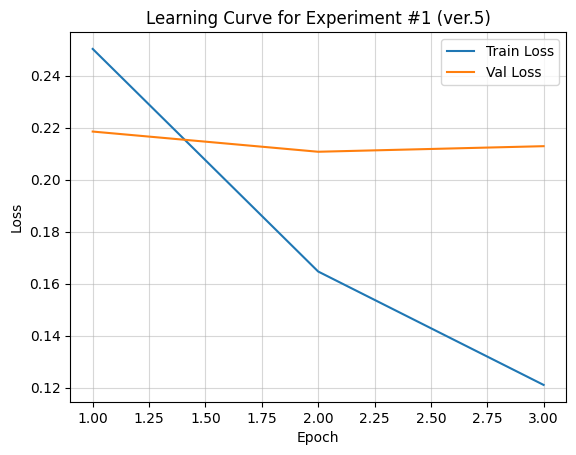

In [20]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], train_losses, label="Train Loss")
plt.plot([1, 2, 3], val_losses, label="Val Loss")

plt.title("Learning Curve for Experiment #1 (ver.5)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.grid(True, alpha=0.5)

plt.show()

## 7. 테스트

In [21]:
model.eval()
test_loss = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        labels = labels.float().to(device)
        labels = labels.unsqueeze(1)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits

        loss = criterion(logits, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).long().squeeze()

        test_preds.extend(preds.cpu().tolist())
        test_labels.extend(labels.cpu().squeeze().tolist())

test_accuracy = accuracy_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds, average="binary")
test_precision = precision_score(test_labels, test_preds, average="binary")
test_f1 = f1_score(test_labels, test_preds, average="binary")

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

print(f"테스트 데이터 Accuracy: {test_accuracy:.4f}")
print(f"테스트 데이터 f1: {test_f1:.4f}")
print(f"테스트 데이터 recall: {test_recall:.4f}")
print(f"테스트 데이터 precision: {test_precision:.4f}")

Test Loss: 0.1868
테스트 데이터 Accuracy: 0.9288
테스트 데이터 f1: 0.9285
테스트 데이터 recall: 0.9244
테스트 데이터 precision: 0.9326
